# Exercises

In [1]:
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import sys 
from scipy.signal import butter, sosfilt

sys.path.append('code/')

import lfp_functions as lf

## Exercise 1: explore filter parameters
---
In this exercises you will explore how different parameters affect the filtering process.
- Import the data form `data/moving_lfp.pickle` (the file is already on your machine if you run the `download_data()` cell in the main lesson)
- Take a few seconds of the data, and filter them in different frequency bands. Plot the resulting singal.
  Fix the central frequency and play with the width of the band, then try to change the central frequency of the band.
- Change the order of the filter, keeping the frequency band fixed. How does the filtered signal change? How does the computing time change? (You can try to quantify the computing time with the jupyter magic command [`%timeit`](https://docs.python.org/3/library/timeit.html) )
- Comment on what you see

In [2]:
def plot_frequency_bands(
        frequency_bands, sample, sampling_rate, time, title = "LFP signal and frequency bands", filter_order = 5):
    fig, ax = plt.subplots(6, 1, figsize=(10, 10))
    
    """Function to plot different frequency bands of a signal and the signal itself."""

    fig.suptitle(title)

    for i, (band, (low_f, high_f)) in enumerate(frequency_bands.items()):
        if band == 'signal':
            band_lfp = sample.copy()
        else:
            band_lfp = lf.bandpass_filter(sample, low_f=low_f, high_f=high_f, sampling_rate = sampling_rate, filter_order = filter_order)
        ax[i].plot(time, band_lfp)
        ax[i].set_title(band)
        ax[i].set_ylabel("Amplitude")
        ax[i].set_xlabel("Time (s)")

    plt.tight_layout()
    plt.show()


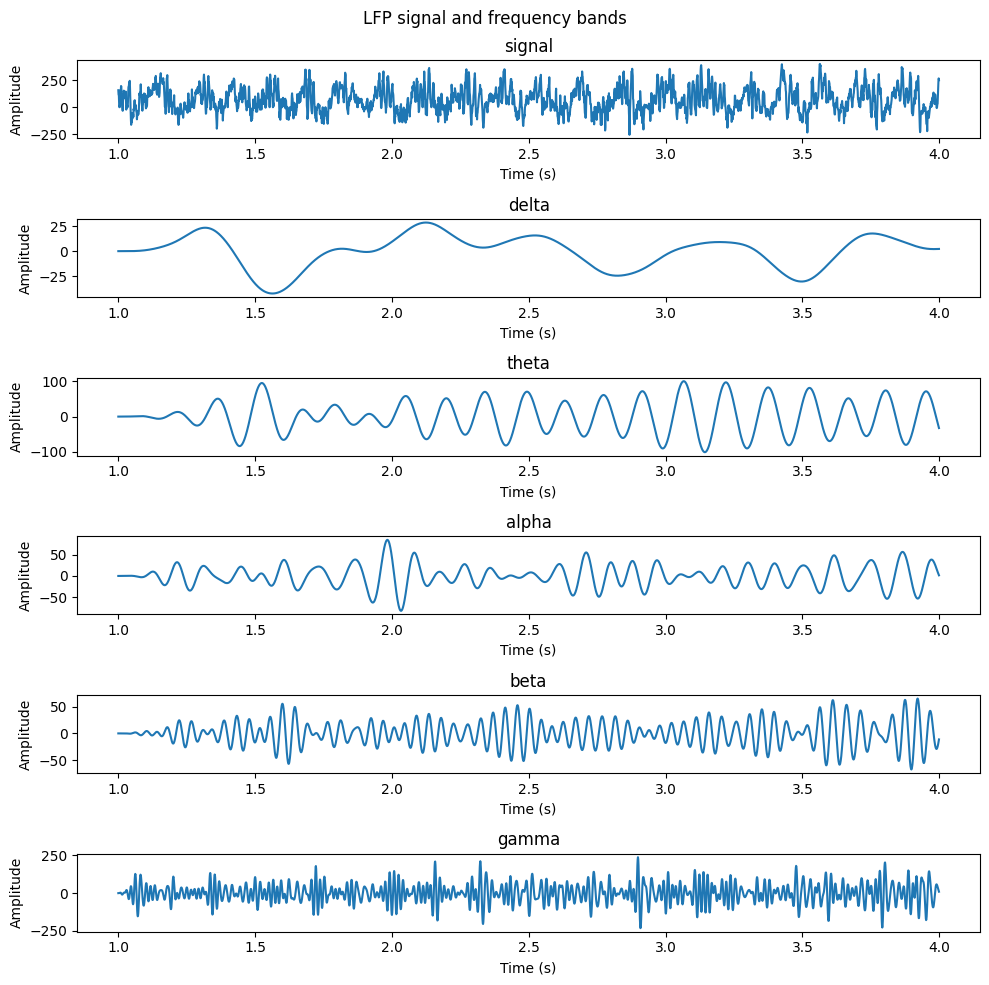

In [3]:

# import data
with open('data/moving_lfp.pickle', 'rb') as f:
    data = pickle.load(f)

lfp = data['lfp']
sampling_rate = data['sampling_rate']

# pick sample and set parameters
lfp_sample = lfp[1000:4000]
dt = 1/sampling_rate
n_samples = lfp_sample.shape[0]
time = np.arange(0, n_samples*dt, dt) + 1000*dt

# plot signal and frequency bands
frequency_bands = {'signal': (0,0), 'delta': (0.5, 2.5), 'theta': (3.5, 7), 'alpha': (8, 13), 'beta': (18, 25), 'gamma': (30, 70)}
plot_frequency_bands(frequency_bands, lfp_sample, sampling_rate, time)


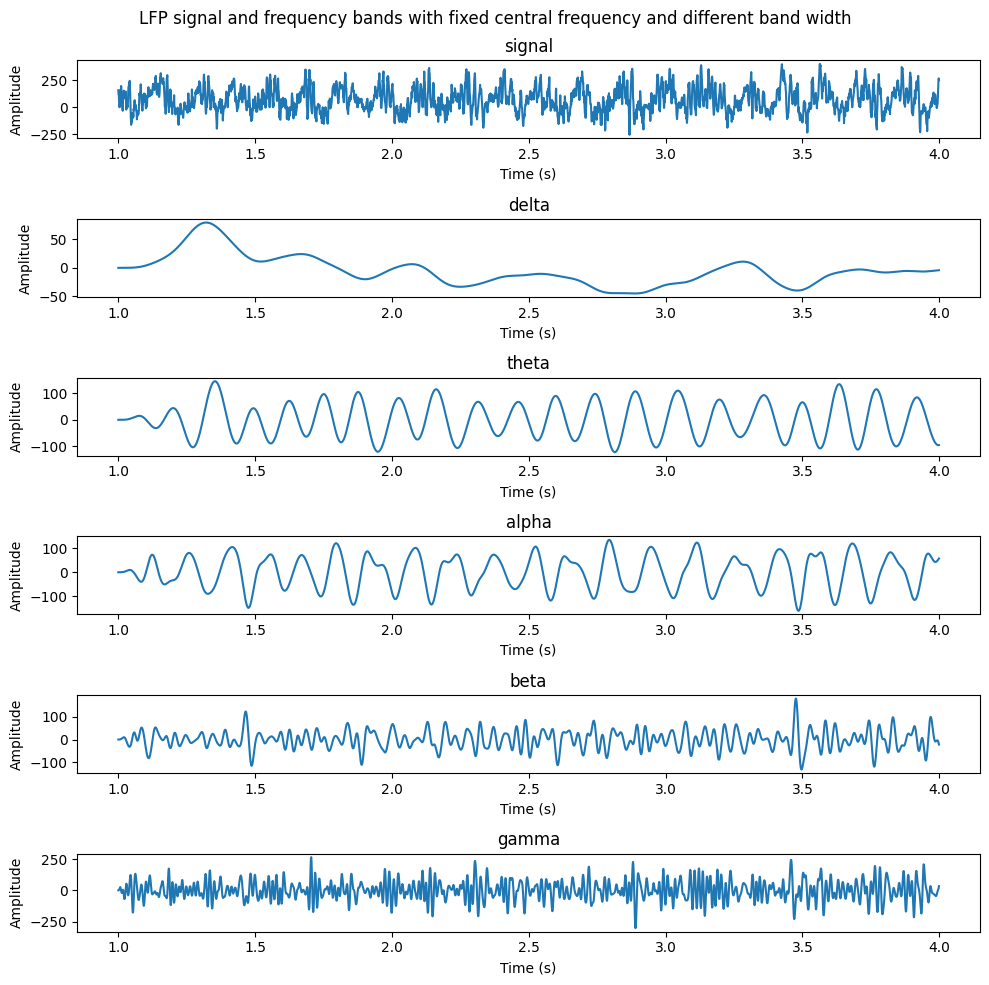

In [4]:
# fix central frequency and change width of the bands:
frequency_bands = {'signal': (0,0), 'delta': (0.1, 2.9), 'theta': (2, 8.5), 'alpha': (5, 16), 'beta': (10, 33), 'gamma': (15, 85)}
plot_frequency_bands(frequency_bands, lfp_sample, sampling_rate, time,
                     title = "LFP signal and frequency bands with fixed central frequency and different band width")


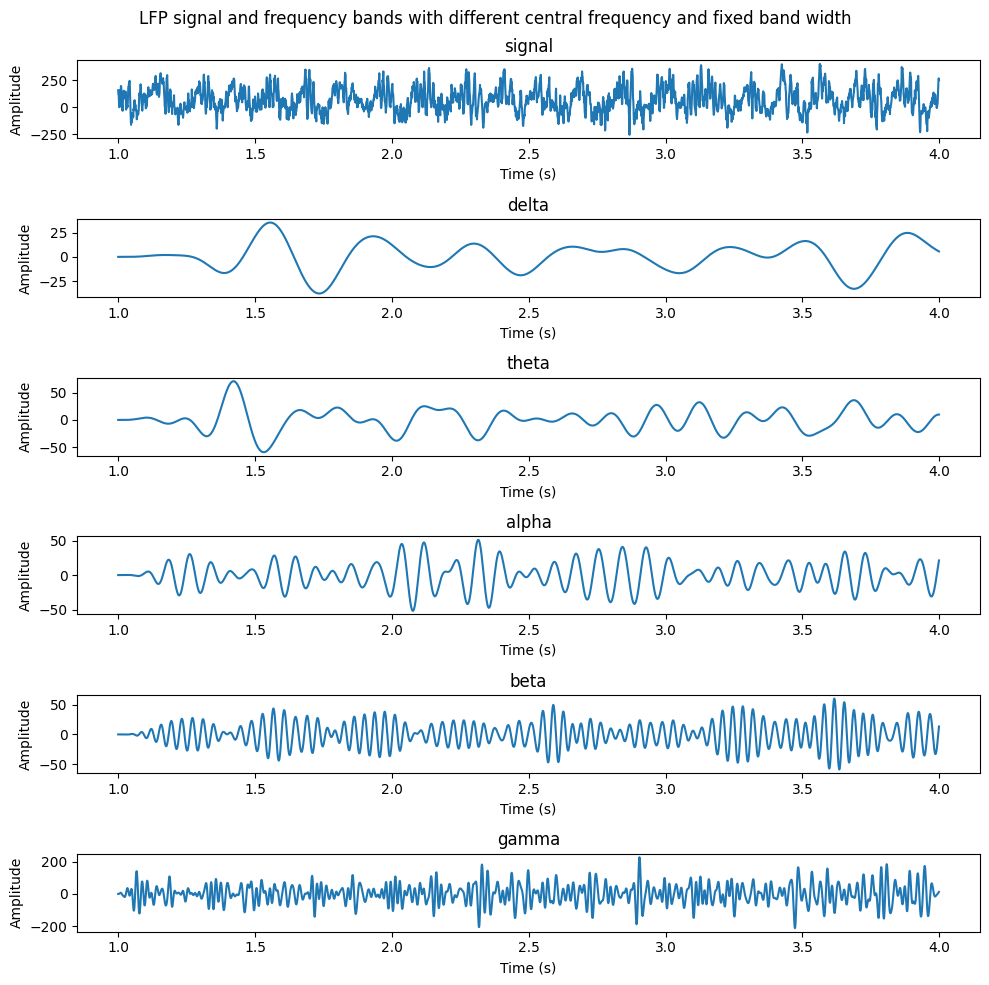

In [5]:
# Changing central frequency of bands
frequency_bands = {'signal': (0,0), 'delta': (1.5, 3.5), 'theta': (2.0, 5.5), 'alpha': (10, 15), 'beta': (23, 30), 'gamma': (20, 60)}
plot_frequency_bands(frequency_bands, lfp_sample, sampling_rate, time,
                     title = "LFP signal and frequency bands with different central frequency and fixed band width")

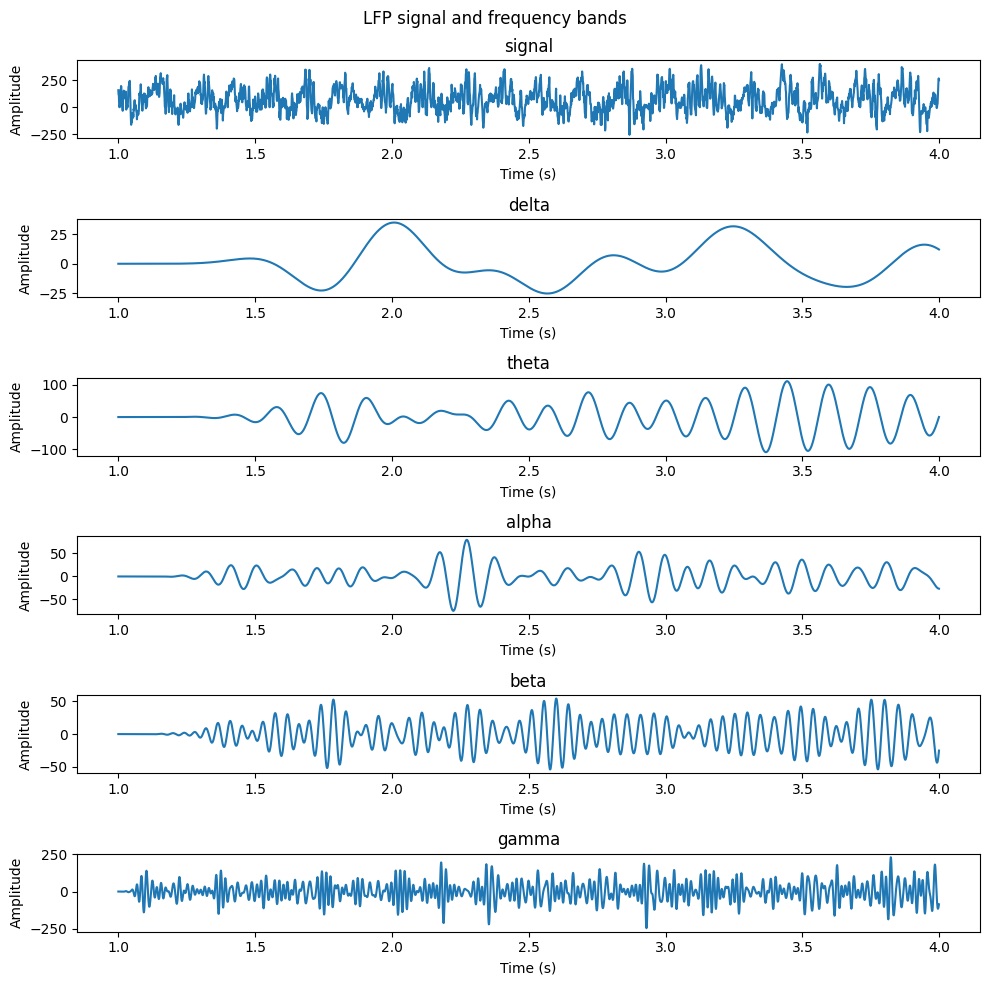

In [6]:
# plot signal with higher filter order
frequency_bands = {'signal': (0,0), 'delta': (0.5, 2.5), 'theta': (3.5, 7), 'alpha': (8, 13), 'beta': (18, 25), 'gamma': (30, 70)}
plot_frequency_bands(frequency_bands, lfp_sample, sampling_rate, time, filter_order=10)

In [7]:
## Time the filter for different filter orders

low, high = frequency_bands["alpha"]

for i in np.arange(5,25,5):
    print(f"Filter order: {i}")
    %timeit lf.bandpass_filter(lfp_sample, low_f=low, high_f=high, sampling_rate = sampling_rate, filter_order = i)


Filter order: 5
2.14 ms ± 363 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
Filter order: 10
3.55 ms ± 611 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
Filter order: 15
5.09 ms ± 1.17 ms per loop (mean ± std. dev. of 7 runs, 100 loops each)
Filter order: 20
5.09 ms ± 1.03 ms per loop (mean ± std. dev. of 7 runs, 100 loops each)


### Comments Ex. 1:
- Broader frequency bands with fixed central frequencies lead to more overlap in the signal between frequency bands. This is to be expected since now the frequencies of different bands overlap.
- Changing the central frequencies of the different bands leads to a change in the signal. Interestingly, between 22 and 30 Hz a clear oscillatory pattern emerges in the signal which was not quite as clear in the beta frequency band (18-25 Hz).
- Changing the filter order leads to higher temporal precision at the cost of computation time and shifting of the signal to the right. The computation time seems to scale linearly with the filter order.

## Exercise 2: wavelet transform with real wavelets
---
In this exercises you will explore the difference between real and complex wavelets in the continous wavelet transform.
- Import the data form `data/moving_lfp.pickle`
- Select a period of a few seconds of the signal and compute the spectrogram. 
  Try the wavelet transform with wavelet `mexh` (mexican hat),`gaus` (gaussian) and `morl` (morlet). These are all real wavelets.
- What differences do you see with respect to the spectrum computed with the complex Morlet tranform ? Comment on why do you think this might be the case.

/usr/local/Caskroom/miniforge/base/envs/neural_data/lib/python3.11/site-packages/pywt/_functions.py:143: FutureWarning: Wavelets from the family cmor, without parameters specified in the name are deprecated. The name should takethe form cmorB-C where B and C are floats representing the bandwidth frequency and center frequency, respectively (example: cmor1.5-1.0).
  wavelet = DiscreteContinuousWavelet(wavelet)
/usr/local/Caskroom/miniforge/base/envs/neural_data/lib/python3.11/site-packages/pywt/_cwt.py:117: FutureWarning: Wavelets from the family cmor, without parameters specified in the name are deprecated. The name should takethe form cmorB-C where B and C are floats representing the bandwidth frequency and center frequency, respectively (example: cmor1.5-1.0).
  wavelet = DiscreteContinuousWavelet(wavelet)


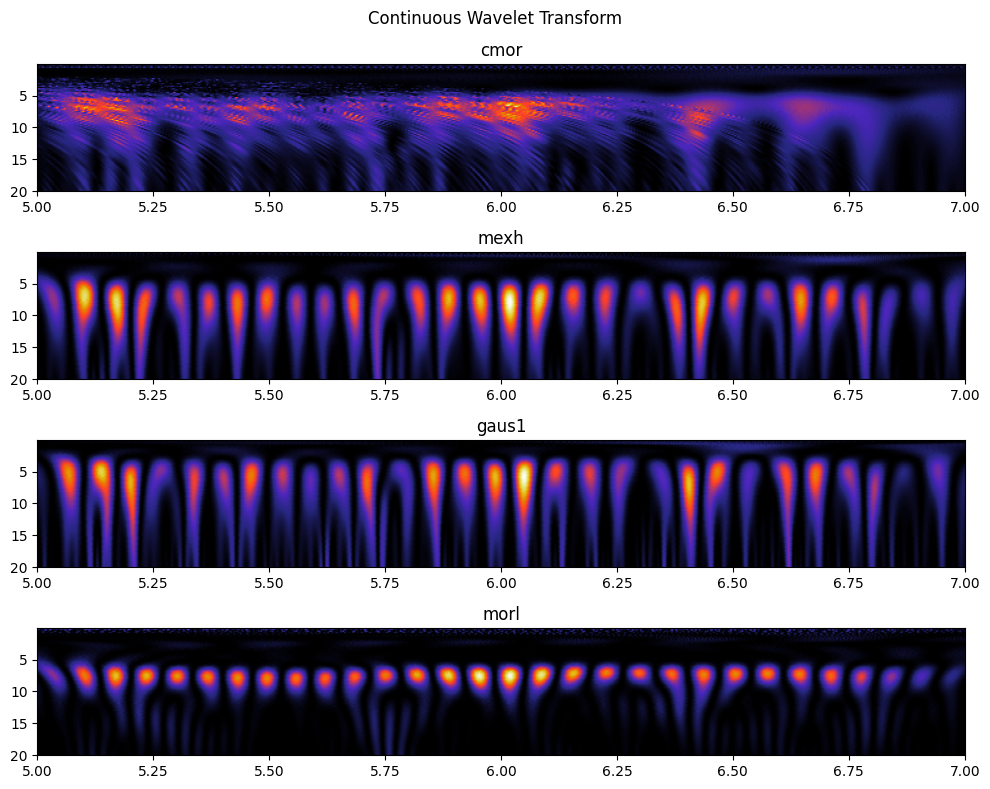

In [8]:
from pywt import scale2frequency
from pywt import cwt
from scipy.signal import morlet

# set parameters
start, end = 5, 7 

sig = lfp[int(start*sampling_rate):int(end*sampling_rate)]
sig = sig - np.mean(sig) 

wavelets = ["cmor", "mexh", "gaus1", "morl"]

# plot continuous wavelet transform
fig, ax = plt.subplots(len(wavelets), 1, figsize=(10, 8))
fig.suptitle("Continuous Wavelet Transform")

for i, wavelet in enumerate(wavelets):
    frequencies =  np.linspace(0.1,20,100)/sampling_rate
    scales = scale2frequency(wavelet, frequencies)
    cwtmatr, _ = cwt(sig, wavelet=wavelet, scales=scales,
                    sampling_period=1.0/sampling_rate)
    ax[i].imshow(abs(cwtmatr)**2, extent=[start,end,frequencies[-1]*sampling_rate,
                            frequencies[0]*sampling_rate], aspect='auto', cmap='CMRmap')
    ax[i].set_title(wavelet)

plt.tight_layout()
plt.show()

### Comments Ex. 2:
- All the real wavelet transformations show clear alternating patterns of high power and low power in particular frequency ranges, particularly in the theta and alpha range. The complex morlot wavelet shows temporal smearing where these alternating patterns are not detectible
- This is likely due to the fact that the real wavelet only consists of one function per frequency range and cannot span the full space since it has low power alternating with higher power due to its oscillatory nature. By complementing it with its complex counterpart, one of the two functions always has high power and hence signal at all time points can be detected.

## Exercise 3: REM sleep detection
---
Mammalian sleep is organized in different phases. [Rapid Eye Movement (REM) sleep](https://en.wikipedia.org/wiki/Rapid_eye_movement_sleep) is a well studied phase, with clear markers that make it detectable from LFP data. One of the most used marker is the ratio (or difference) between the oscillatory power in the theta and delta bands in the hippocampus. During REM sleep, the former dominates, in a pattern that resembles active behaviour.  
In this exercise we will use the tools we learned about to detect and inspect the REM and non-REM (nREM) phases of sleep in data recorded from the hippocampus of a sleeping mouse.

- Import the data form `data/moving_lfp.pickle`
- Compute the instantaneous power in the theta (6-10 Hz) and delta (2-4 Hz) frequency bands, for the whole signal.
- z-score the two power signals (subtract the mean and divide by the standard deviation, you can use `scipy.stats.zscore()`)
- Compute and plot the power difference (`theta_power - delta_power`) for the sleep session.
- Compute the REM (power difference $>0.2$) and nREM (power diffewrence $<0.2$) sleep periods.
- Plot examples of REM vs nREM lfp signals (wideband filtered betw. 1 and 200 Hz to get rid of some of the noise).
- Explore how changing the threshold affects the amount of REM sleep detected.

In [9]:
from scipy.fft import fft, fftfreq
from scipy.stats import zscore

# load data
with open('data/moving_lfp.pickle', 'rb') as f:
    data = pickle.load(f)

lfp = data['lfp']
centered_lfp = lfp - np.mean(lfp) # center data

# set parameters
sampling_rate = data["sampling_rate"]
dt = 1/sampling_rate
n_samples = len(centered_lfp)

start, end = 0, n_samples/sampling_rate

freq_bands = {"delta": {"limits" : (2,4)},
              "theta": {"limits" : (6,10)}}

# calculate power for each frequency band using FFT and morlot wavelet
for band, value in freq_bands.items():
    low, high = value["limits"]
    frequencies =  np.linspace(low,high,50)/sampling_rate

    wavelet = 'cmor1.0-1.0'
    scales = scale2frequency(wavelet, frequencies)
    cwtmatr, _ = cwt(lfp, wavelet=wavelet, scales=scales,
                    sampling_period=dt)

    power = np.mean(abs(cwtmatr)**2,axis=0)
    z_power = zscore(power)

    freq_bands[band]["z_power"] = z_power


In [10]:

class Interval:
    """Dummy Class to store intervals."""
    
    def __init__(self, start = None, end = None):
        self.start = start
        self.end = end

    def __repr__(self):
        return f"Interval({self.start}, {self.end})"

In [11]:
def plot_rem_vs_non_rem_sleep(power_difference, threshold):
    """Function to plot NREM and REM sleep periods which finds intervals if (non)REM sleep based on a threshold."""

    fig, ax = plt.subplots(2, 1, figsize=(10, 6))
    fig.suptitle(f"NREM and REM sleep, threshold = {threshold}")

    # loop over non-REM and REM sleep
    for idx in [0,1]:

        # isolate phases based on threshold for non-REM and REM sleep
        if idx == 0:
            sleep_phases = np.where(power_difference > threshold)[0]
        else:
            sleep_phases = np.where(power_difference <= threshold)[0]

        # find all intervals for sleep phases
        sleep_periods = []

        for i in range(len(sleep_phases)):
            if i != 0 and sleep_periods[-1].end == sleep_phases[i]-1:
                sleep_periods[-1].end = sleep_phases[i]
            else:
                sleep_periods.append(Interval(start = sleep_phases[i], end = sleep_phases[i]))

        # save only those sleep phases which are longer than 1 second
        long_periods = [i for i in sleep_periods if i.end - i.start > 1000]

        # pick first (only) long period for REM and second for non-REM since first one is at the beginning of recording
        if idx == 0:
            start, end = long_periods[0].start, long_periods[0].start + 1000
        else:
            start, end = long_periods[1].start, long_periods[1].start + 1000

        lfp_period = lfp[start:end]

        # bandpass filter to remove high frequency noise and low frequency drift
        band_lfp_period = lf.bandpass_filter(lfp_period, low_f=1, high_f=200, sampling_rate = sampling_rate, filter_order = 5)

        # plot
        ax[idx].plot(np.arange(start, end, 1)/sampling_rate, band_lfp_period)
        ax[idx].set_title("NREM sleep" if idx == 1 else "REM sleep")
        ax[idx].set_xlabel("Time (s)")
        ax[idx].set_ylabel("Amplitude")
        ax[idx].set_ylim(-350, 350)
        ax[idx].grid()

    plt.tight_layout()
    plt.show()


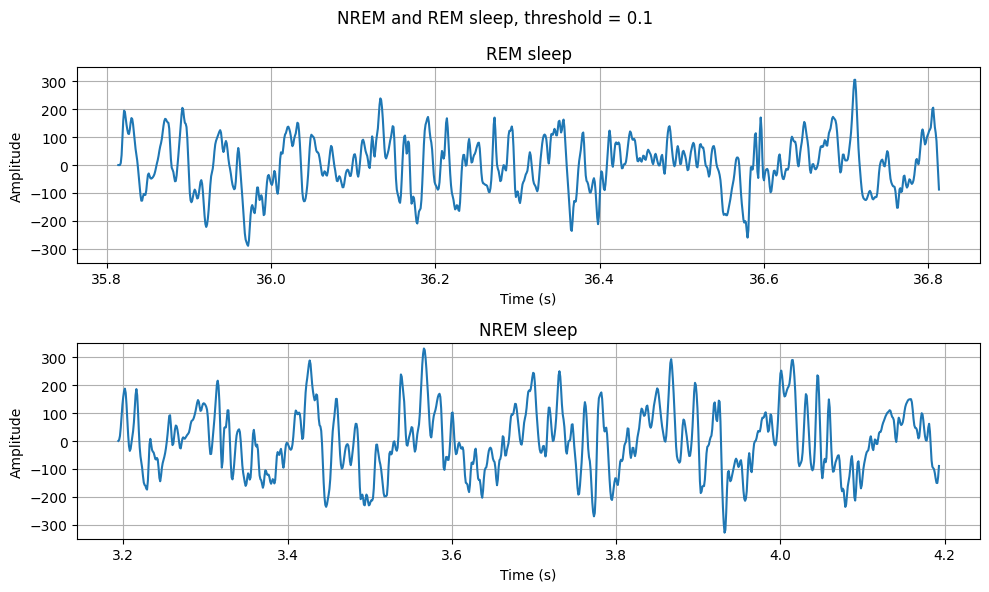

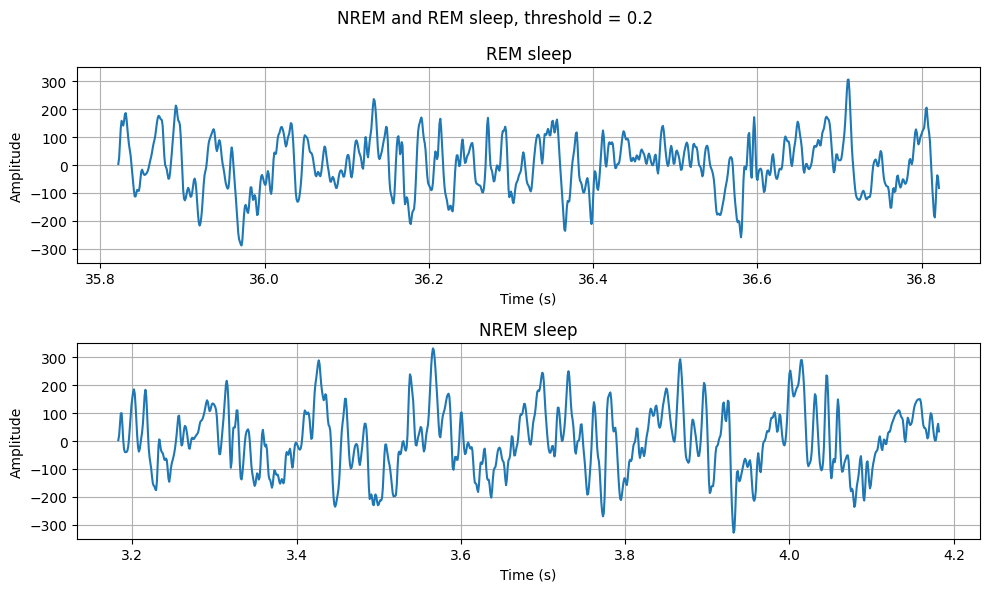

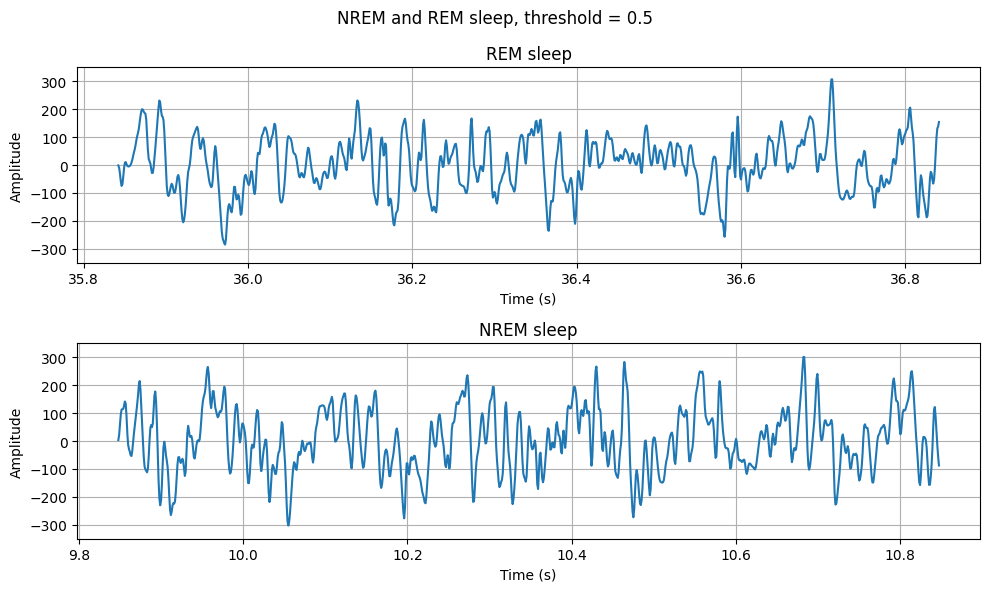

In [12]:
# compute power difference based on instructions
power_difference = freq_bands["delta"]["z_power"] - freq_bands["theta"]["z_power"]

# loop over different thresholds and plot
for threshold in [0.1, 0.2, 0.5]:
    plot_rem_vs_non_rem_sleep(power_difference, threshold)

Overall, most of the activity in REM-sleep seems to be of higher frequency compared to the activity in non-REM-sleep. Increasing the threshold makes this difference less pronounced while decreasing it enhances this difference. 